# Elman-style syntax extraction models

In this project, we will first replicate Elman's (1990) results on discovering linguistic structure. We will then expand his results, using a broader and more naturalistic corpus.

Elman's contributions are foundational to modern artificial intelligence. His (1990) paper introduced recurrent neural networks, which have played a pivotal role in NLP. Moreover, the results Elman obtained are an impressive demonstration of the capacity of neural networks to learn syntactic and semantic categories.

### Packages
We begin by importing the packages we will need.

In [117]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import random
from tqdm import tqdm
from torch.distributions.categorical import Categorical

plt.style.use('dark_background')

RANDOM_SEED = 0
# random.seed(RANDOM_SEED)

### Loading the data
We begin by using Elman's original dataset. Elman's data was generated by a simple categorial grammar: we specify a set of sentence structures consisting of placeholder syntactic and semantic categories (such as `NOUN-ANIMATE`, `VERB-TRANSITIVE`, or `NOUN-FOOD`) as well as a list of lexical items for each category. Generating the data then consists in randomly choosing a sentence template and replacing each lexical category in the template by a word from that category. The words in each category are specified by hand.

We generate the `10_000` sentences of data in a separate file. Here, we load and process the data. Each word (token) in the vocabulary is represented by a number. Each training example is stored as as tensor of indices representing the corresponding words in the sentence.

In [118]:
# load sentences
with open('data/elman_sentences.txt', 'r') as fid:
    lines = fid.readlines()

# strip trailing whitespace
stripped_sentences = [l.strip() for l in lines]
# tokenize sentences
tokenized_sentences = [s.split() for s in stripped_sentences]
# add start and end of sentence markers
tokenized_sentences = [['<SOS>'] + s + ['<EOS>'] for s in tokenized_sentences]
# count tokens
unique_tokens = sorted(set(sum(tokenized_sentences, [])))
n_tokens = len(unique_tokens)
# mapping tokens to ints and vice-versa
tokens_to_ints = {t : i for i, t in enumerate(unique_tokens)}
ints_to_tokens = {i : t for i, t in enumerate(unique_tokens)}


# mapping sentences (=lists of tokens) to tensors of ints
def sentence_to_tensor(token_list):
    indices = [tokens_to_ints[t] for t in token_list]
    return torch.tensor(indices)


# tensors of token indices representing sentences
training_tensors = [sentence_to_tensor(s) for s in tokenized_sentences]
n_train = len(training_tensors)

Let us illustrate our processing of the data.

In [119]:
print(f"Number of examples: {n_train}")
print(f"Number of unique tokens (including <SOS> and <EOS>): {n_tokens}")
print(f"Example tokenized sentence: {tokenized_sentences[0]}")
print(f"Corresponding tensor: {training_tensors[0]}")
print(f"Shape of tensor: {training_tensors[0].shape}")

Number of examples: 10000
Number of unique tokens (including <SOS> and <EOS>): 31
Example tokenized sentence: ['<SOS>', 'monster', 'break', 'plate', '<EOS>']
Corresponding tensor: tensor([ 1, 19,  5, 22,  0])
Shape of tensor: torch.Size([5])


### Building the model
We now define a simple recurrent network inspired by Elman's own (1990) proposal. Elman uses a one-hot encoding of the vocabulary. In line with contemporary NLP practice, we will instead use a continuous embedding vector (of size `hidden_size=20`) to represent the vocabulary.

The hidden layer has size `hidden_size` and a logistic activation function.

The output layer has size `vocab_size` and a softmax activation function, defined by$$\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}.$$ As a result, the network computes the probability $P(w_i| w_{i-1},\dots, w_1)$ of the next word $w_i$ given past words $w_1, \dots, w_{i -1}$.

As is standard, we use the negative log-likelihood loss `nn.NLLLoss`, and we use the `AdamW` optimizer as it has been found to provide good performance.

In [120]:
class SRN(nn.Module):

    def __init__(self, vocab_size, hidden_size):
        # vocab_size : number of tokens in vocabulary including special tokens <SOS> and <EOS>
        # hidden_size : dimension of input embeddings and hidden layer
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size,hidden_size)
        self.hidden_layer = nn.Linear(hidden_size * 2, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        self.sigmoid = nn.Tanh()
        self.softmax = nn.Softmax(dim=0) # nn.LogSoftmax(dim=1) ?
        

    def forward(self, input, hidden):
        input_embed = self.embed(input) # 1D tensor of size hidden_size
        
        # concatenate input and hidden
        combined = torch.cat((input_embed, hidden))
        # pass through hidden layer
        hidden = self.hidden_layer(combined)
        hidden = self.sigmoid(hidden)
        # compute output
        output = self.output_layer(hidden)
        # output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        # Initializes the hidden layer to the 0 vector
        return torch.zeros(self.hidden_size)
    
    def get_embeddings(self):
        # Returns numpy array of input embeddings, of shape (vocab_size, hidden_size)
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

#### Hyperparameters

In [121]:
hidden_size = 20
n_epochs = 2
rnn = SRN(n_tokens, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001) # w/ default learning rate 0.001

### Training the model
To train our model, we feed it the sentences in the training set. For each sentence, we ask the model to predict the next work in the sentence, given the previous words. We collect these predictions, then calculate the average loss across the sentence. We take an optimizer step after each sentence.

In [126]:
def train(sentence_tensor, rnn):
    hidden = rnn.initHidden()
    sentence_loss = 0

    inputs = sentence_tensor[:-1]
    targets = sentence_tensor[1:]
    torch.autograd.set_detect_anomaly(True)

    for input, target in zip(inputs, targets):
        optimizer.zero_grad()
        output, hidden = rnn(input, hidden)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        sentence_loss += loss.item()

    # backprop
    return sentence_loss

In [127]:
# Training loop
errors = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1} in training...")
    randomized_train_ex = random.sample(training_tensors, n_train)
    
    for sentence_tensor in tqdm(randomized_train_ex):
        sentence_loss = train(sentence_tensor, rnn)
        errors.append(sentence_loss)

Epoch 1 in training...


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/paultalma/miniconda3/envs/elman/lib/python3.12/site-packages/torch/autograd/graph.py:769: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/paultalma/miniconda3/envs/elman/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/paultalma/miniconda3/envs/elman/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/paultalma/miniconda3/envs/elman/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/Users/paultalma/miniconda3/envs/elman/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/Users/paultalma/miniconda3/envs/elman/l

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [40, 20]], which is output 0 of AsStridedBackward0, is at version 4; expected version 3 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

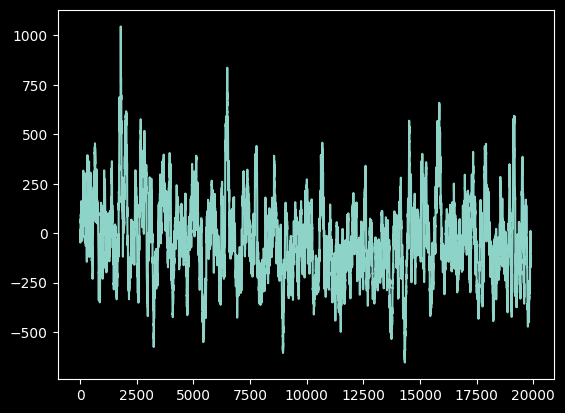

Final error: 1846.9545931100845


In [82]:
def rolling_avg(lst, window):
    return (np.cumsum(lst[window:]) - np.cumsum(lst[:-window])) / window

plt.plot(rolling_avg(errors, 100))
plt.show()

final_error = sum(errors[-100:])/100
print(f"Final error: {final_error}")

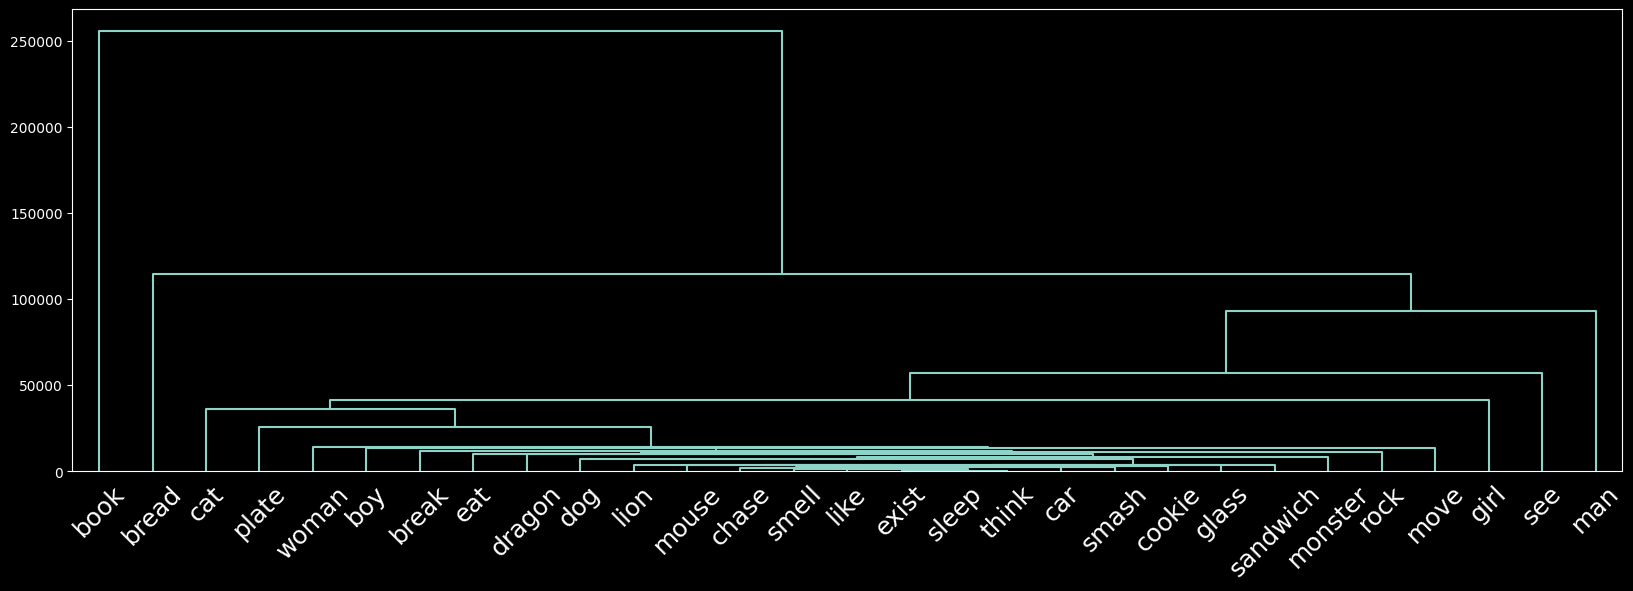

In [78]:
def plot_dendo(X, names, exclude=["<SOS>", "<EOS>"]):
    """
    Show hierarchical clustering of vectors
    
    Input
        X : numpy tensor [nitem x dim] such that each row is a vector to be clustered
        names : [length nitem] list of item names
        exclude: list of names we want to exclude
    """
    names = np.array(names)
    include = np.array([myname not in exclude for myname in names], dtype=bool)
    linked = linkage(X[include], "single", optimal_ordering=True)
    plt.figure(1, figsize=(20, 6))
    dendrogram(linked, labels=names[include], color_threshold=0, leaf_font_size=18)
    plt.show()


plot_dendo(rnn.get_embeddings(), unique_tokens)

(Note: your exact results may vary, but the general picture should be similar.)

We see that the model's embeddings encode significant information. The model seems to recover some of the categories built into the grammar (see the grammar.py file), classifying ['boy', 'man', 'girl', 'woman'] together, as well as ['dragon', 'monster', 'lion'] and ['cat', 'dog', 
'mouse'].

However, the model is not perfect: it fails to recover the `ANIMATE` category, as it places certain verbs like 'smell', 'eat', and 'chase'  etc. closer to 'man', 'woman', 'boy' than 'dragon', 'monster', and 'lion', all of which are animate.

Just for fun, let's see what sentences the model is able to generate.

In [30]:
def list_to_sentence(ls):
    sent = ""
    for word in ls:
        sent += word + " "
    return sent.strip()

def generate_sentence(max_len=15):
    
    # token = torch.tensor(random.randint(2, 30))
    token = torch.tensor(1)
    word = ints_to_tokens[int(token.item())]
    sentence = [word]
    # sentence = []
    hidden = rnn.initHidden()

    for _ in range(max_len):
        output, hidden = rnn(token, hidden)
        # token = torch.argmax(output)
        m = Categorical(output)
        token = m.sample()
        word = ints_to_tokens[int(token.item())]
        sentence.append(word)
        if word == '<EOS>':
            break

    return list_to_sentence(sentence)


for i in range(10):
    print(f"Sentence no. {i+1}: {generate_sentence()}")


Sentence no. 1: <SOS> woman <EOS>
Sentence no. 2: <SOS> woman <EOS>
Sentence no. 3: <SOS> woman <EOS>
Sentence no. 4: <SOS> woman <EOS>
Sentence no. 5: <SOS> woman <EOS>
Sentence no. 6: <SOS> woman <EOS>
Sentence no. 7: <SOS> woman <EOS>
Sentence no. 8: <SOS> woman <EOS>
Sentence no. 9: <SOS> woman <EOS>
Sentence no. 10: <SOS> woman <EOS>
